In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt 
import quantum
import model
import energy_surface as Esurf
from oneDim.main import kinetic_energy_functional as Ekf

In [2]:
fname = '../optimAlpha'
with open(fname, 'rb') as f:
    alpha_optim = pickle.load(f)

dataname = '../densG_T_dT'
gamma = 0.1
C_ = 1e-4
KRR = model.model(dataname, gamma, C_)
alpha_origin = KRR.dual_coef_
Xi = KRR.X_fit_.T

trainname = '../train_data'
testname = '../test_data'
with open(trainname, 'rb') as f1:
    train_data = pickle.load(f1)
with open(testname, 'rb') as f2:
    test_data = pickle.load(f2)

...processing data
train/test data saved...
...model training
model testing err: 0.0016


In [3]:
train_dens, train_Ek, train_dEk = train_data[:, :51], train_data[:, 51], train_data[:, 52:]
test_dens, test_Ek, test_dEk = test_data[:, :51], test_data[:, 51], test_data[:, 52:]

## Performance of model on testing dataset (derivative)

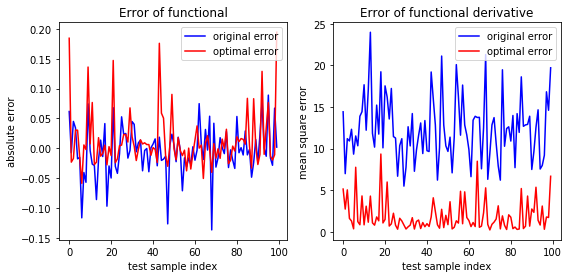

In [146]:
T_origin = Ekf.kinetic_dens(test_dens, alpha_origin, Xi, gamma)
T_optim = Ekf.kinetic_dens(test_dens, alpha_optim, Xi, gamma)
Terr_origin = T_origin - test_Ek
Terr_optim = T_optim - test_Ek

dTdn_origin = Ekf.kinetic_deriv_dens(test_dens, alpha_origin, Xi, gamma)
dTdn_optim = Ekf.kinetic_deriv_dens(test_dens, alpha_optim, Xi, gamma)
dTerr_origin = np.linalg.norm((dTdn_origin - test_dEk), axis=1)**2
dTerr_optim = np.linalg.norm((dTdn_optim - test_dEk), axis=1)**2
X_index = range(test_dEk.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.plot(X_index, Terr_origin, 'b', label='original error')
ax1.plot(X_index, Terr_optim, 'r', label='optimal error')
ax1.set_xlabel('test sample index')
ax1.set_ylabel('absolute error')
ax1.set_title('Error of functional')
ax1.legend()
ax2.plot(X_index, dTerr_origin, 'b', label='original error')
ax2.plot(X_index, dTerr_optim, 'r', label='optimal error')
ax2.set_xlabel('test sample index')
ax2.set_ylabel('mean square error')
ax2.set_title('Error of functional derivative')
ax2.legend()
plt.savefig('Error_on_testset.png')
plt.show()

## Energy surface around the true solution

In [96]:
n, V0, dmu = 4, 20, 15
_, mu_true, en_band, Vq_true, densG_true = quantum.quantum(n, V0, dmu)

In [97]:
from importlib import reload
reload(Esurf)

<module 'energy_surface' from '/Users/hongbinren/Documents/program/oneDim/tools/energy_surface.py'>

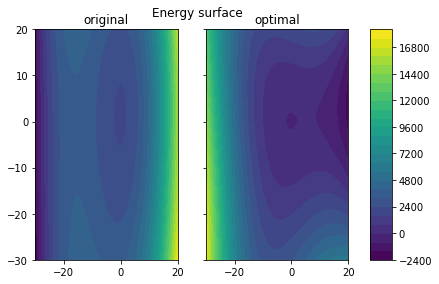

In [101]:
i, j = 1, 4
energy_origin, dxx, dyy = Esurf.energy_surface(i, j, mu_true, gamma, densG_true, Vq_true, alpha_origin, Xi)
energy_optim, _, _ = Esurf.energy_surface(i, j, mu_true, gamma, densG_true, Vq_true, alpha_optim, Xi)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
img = ax1.contourf(dxx, dyy, energy_origin, 30)
ax1.set_title('original')
ax2.set_title('optimal')
img = ax2.contourf(dxx, dyy, energy_optim, 30)
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
ax_bar = fig.add_axes([0.9, 0.1, 0.05, 0.8])
plt.colorbar(img, cax=ax_bar)
plt.suptitle('Energy surface')
plt.show()

## Performance of direct minimization

In [107]:
def hamilton(densG, Vq, mu, alpha, n=4, Xi=Xi, gamma=gamma, lambda1=100):
    assert len(Vq) == len(densG)
    Ek = Ekf.kinetic_dens(densG.reshape(1, -1), alpha, Xi, gamma)
    dens_neq = np.r_[densG[0], densG[1:][::-1]]
    Mu = np.zeros_like(densG)
    Mu[0] = mu
    return Ek + ((Vq - Mu) @ dens_neq).real + lambda1*(densG[n:-n] @ densG[n:-n]).real

In [111]:
# def hamilton1(phiG, Vq, mu, alpha, n=3, Xi=Xi, gamma=gamma, lambda1=100):
#     nG = len(Vq)
#     densx = (np.fft.ifft(phiG)*nG)**2
#     densG = np.fft.fft(densx)/nG
#     Ek = Ekf.kinetic_dens(densG.reshape(1, -1), alpha, Xi, gamma)
#     dens_neq = np.r_[densG[0], densG[1:][::-1]]
#     Mu = np.zeros_like(densG)
#     Mu[0] = mu
#     return Ek + ((Vq - Mu) @ dens_neq).real + lambda1*(phiG[n:-n] @ phiG[n:-n]).real

In [138]:
n, dmu = 4, 40
V0_init = 0
_, mu, _, _, densG_init = quantum.quantum(n, V0_init, dmu)
# phix_init = np.sqrt(np.fft.ifft(densG_init)*nG)
# phiG_init = np.fft.fft(phix_init)/nG
V0_final = 10
_, mu_final, _, Vq_final, densG_final = quantum.quantum(n, V0_final, dmu)

In [139]:
from scipy.optimize import minimize

res_origin = minimize(hamilton, densG_init, args=(Vq_final, mu_final, alpha_origin, 4), method='Powell')
print(res_origin.success)
res_final = minimize(hamilton, densG_init, args=(Vq_final, mu_final, alpha_optim, 4), method='Powell')
print(res_final.success)

True
True


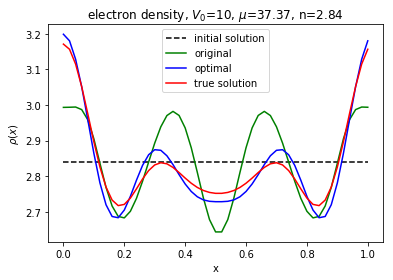

In [147]:
nG = 51
e_num = densG_final[0].real
densG_origin = res_origin.x
densG_optim = res_final.x
densx_init = np.fft.ifft(densG_init)*nG
densx_final = np.fft.ifft(densG_final)*nG
densx_origin = np.fft.ifft(densG_origin)*nG
densx_optim = np.fft.ifft(densG_optim)*nG
X = np.linspace(0, 1, nG)
plt.plot(X, densx_init, 'k--', label='initial solution')
plt.plot(X, densx_origin, 'g', label='original')
plt.plot(X, densx_optim, 'b', label='optimal')
plt.plot(X, densx_final, 'r', label='true solution')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.title(r'electron density, $V_0$={:<=d}, $\mu$={:<=.2f}, n={:<=.2f}'.format(V0_final, mu_final, e_num))
plt.legend()
plt.savefig('density_estimation.png')
plt.show()

In [141]:
E_true = hamilton(densG_final, Vq_final, mu_final, alpha_optim, lambda1=0)[0]
E_optim = hamilton(densG_optim, Vq_final, mu_final, alpha_optim, lambda1=0)[0]
E_origin = hamilton(densG_origin, Vq_final, mu_final, alpha_optim, lambda1=0)[0]
print('Model with true density, ground state energy={:<=.4f}'.format(E_true))
print('Model with optimized density (alpha optimized), ground state energy={:<=.4f}'.format(E_optim))
print('Model with optimized density (alpha original), ground state energy={:<=.4f}'.format(E_origin))

Model with true density, ground state energy=-75.3433
Model with optimized density (alpha optimized), ground state energy=-75.3511
Model with optimized density (alpha original), ground state energy=-75.2270


## Euler equation solver

In [20]:
def equation(densG, Vq, mu, alpha, n=3, Xi=Xi, gamma=gamma, lambda1=100):
    dTdn = Ekf.kinetic_deriv_dens(densG.reshape(1, -1), alpha, Xi, gamma)
    V_neq = np.r_[Vq[0], Vq[1:][::-1]]
    regular = np.r_[np.zeros(n), densG[n:]]
    Mu = np.zeros_like(Vq)
    Mu[0] = mu
    err = dTdn + V_neq - Mu + 2*lambda1*np.sqrt((regular.real)**2 + (regular.imag)**2)
    return err

In [18]:
n, dmu = 4, 40
V0_init = 0
_, mu, _, _, densG_init = quantum.quantum(n, V0_init, dmu)
# phix_init = np.sqrt(np.fft.ifft(densG_init)*nG)
# phiG_init = np.fft.fft(phix_init)/nG

V0_final = 10
_, mu_final, _, Vq_final, densG_final = quantum.quantum(n, V0_final, dmu)

In [21]:
from scipy.optimize import root

sol = root(equation, densG_init, args=(Vq_final, mu_final, alpha_optim), method='broyden1')
print(sol.success)

False


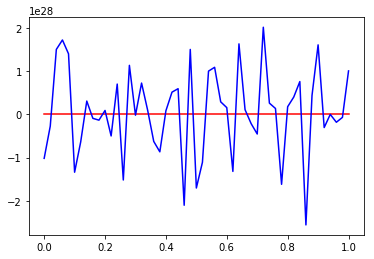

In [22]:
nG = 51
densG_el = sol.x
densx_el = np.fft.ifft(densG_el)*nG
densx_final = np.fft.ifft(densG_final)*nG
X = np.linspace(0, 1, nG)
plt.plot(X, densx_final, 'r')
plt.plot(X, densx_el, 'b')
plt.show()

## Second order derivative

In [73]:
reload(Ekf)

<module 'oneDim.main.kinetic_energy_functional' from '/Users/hongbinren/Documents/program/oneDim/main/kinetic_energy_functional.py'>

In [89]:
n, dmu = 4, 20
V0 = 0
_, mu_free, _, _, densG_free = quantum.quantum(n, V0_init, dmu)
q = 2*np.sqrt(mu_free / (2*np.pi**2))
print(q)
d2Tdn2 = Ekf.kinetic_deriv2_dens(densG_free.reshape(1, -1), alpha_origin, Xi, gamma)
response = -1.0 / d2Tdn2

2.0131684841794812


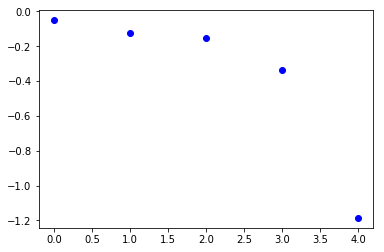

In [92]:
plt.plot(range(5), response[0, :5], 'bo')
plt.show()

In [79]:
mu

40.0